## CSE 144 Applied Machine Learning Final Project Junya's work

Date: 2023/12/10

Name: Junya Ihira

UCSC ID: 1929535

I used the pretrained ViT-H/14 model available in Pytroch and fine-tuned it.

## Import libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision
from importlib import reload
from torchvision.models import vit_h_14, ViT_H_14_Weights
import pandas as pd
from torch.utils.data import DataLoader
from copy import deepcopy
# import function we defined in module
from module import function

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1. Get the prediction

We will get the label probability using fine-tuned ViT-H/14.

### Define the data transform


In [2]:
image_size = 224

test_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
])

### Create the data loader

In [3]:
# Load the dataset
test = function.CustomTestImageDataset(root_dir='../data/raw/test', transform=test_transform)
test_loader = DataLoader(test,shuffle=False)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels tensor([-1])
filename tensor([63])


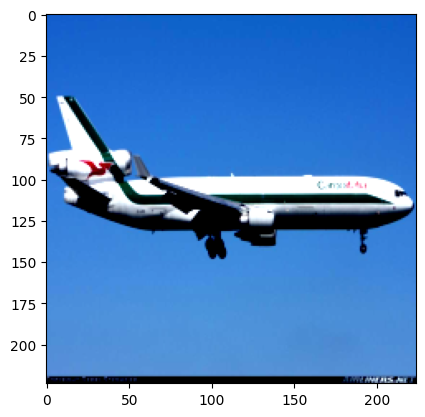

In [4]:
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

for train_batch in test_loader:
    print("labels",train_batch[1])
    print("filename",train_batch[2])
    imshow(torchvision.utils.make_grid(train_batch[0]))
    break

### Load the fine tuned model

In [7]:
# Use the ViT-h/14
model_tuned = vit_h_14()

# Change the last layer
model_tuned.heads= nn.Linear(1280, 512)
# Add dropout layer
dropout_prob = 0.5
model_tuned.heads = nn.Sequential(
    nn.Dropout(dropout_prob),
    model_tuned.heads, 
    nn.Linear(512, 100))

# Load the weights
model_tuned.load_state_dict(torch.load('../models/vit_h_14_fine_tuned40.pth', map_location=torch.device('cpu')))
model_tuned.to(device)

VisionTransformer(
  (conv_proj): Conv2d(3, 1280, kernel_size=(14, 14), stride=(14, 14))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1280, out_features=1280, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=1280, out_features=5120, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=5120, out_features=1280, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
       

### Predict the labels and probabilitiy table

In [8]:
reload(function)
y_prob, y_pred = function.test_loop(model_tuned, test_loader, device=device)
y_prob.to_csv("../data/processed/vit_h14_output.csv", index=False)

## 2. Fine-tune the model
This part aims to fine-tune the model.

### Define the data transform

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
])

# Transfrom for data augmentation
augmentation_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
])


### Create the data loader

In [13]:
# Load the dataset
train = function.CustomTrainImageDataset(root_dir='../data/raw/train', transform=train_transform)

# Test validation ratio
ratio = 0.1
val_size = int(ratio * len(train))
train_size = len(train) - val_size
# Split the dataset into training and validation sets
torch.manual_seed(42)
train, val = torch.utils.data.random_split(train, [train_size, val_size])

# Data augmentation
aug_train = deepcopy(train)
aug_train.dataset.transform = augmentation_transform
# Concatenate the original training set and the augmented training set
train = torch.utils.data.ConcatDataset([train, aug_train])

# Create training and validation dataloaders
batch_size = 32
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False)

### Visualize the training data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels tensor([14, 31, 89, 36, 60, 85, 17, 62, 74, 16, 89, 86, 57, 98, 76, 49, 32, 49,
        18,  2, 15, 57, 42, 96,  9, 53, 63, 91, 83, 78, 66, 15])
filename tensor([ 149,  291,  965,  337,  648,  919,  172,  664,  788,  168,  962,  923,
         616, 1058,  822,  534,  307,  531,  187,   26,  158,  615,  419, 1036,
          92,  579,  671,  984,  892,  837,  702,  159])


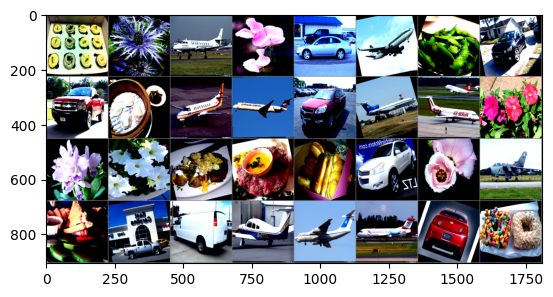

In [4]:
# Visualize one image 
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

for train_batch in train_loader:
    print("labels",train_batch[1])
    print("filename",train_batch[2])
    imshow(torchvision.utils.make_grid(train_batch[0]))
    break

### Define the archtecture of ViT-H/14, loss function and optimizer

In [14]:
# Get the weights of the pretrained model
weights = ViT_H_14_Weights.IMAGENET1K_SWAG_LINEAR_V1
# Get the pretrained model
model = vit_h_14(weights=weights)

# Change the last layer
model.heads= nn.Linear(1280, 512)
# Make the parameter of the last layer trainable
for param in model.parameters():
    param.requires_grad = False
model.heads.weight.requires_grad = True
model.heads.bias.requires_grad = True

# Add dropout layer and the last layer
dropout_prob = 0.5
model.heads = nn.Sequential(
    nn.Dropout(dropout_prob),
    model.heads, 
    nn.Linear(512, 100))


# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), weight_decay=1e-5, lr=0.00005)
model = model.to(device)
model

VisionTransformer(
  (conv_proj): Conv2d(3, 1280, kernel_size=(14, 14), stride=(14, 14))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1280, out_features=1280, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=1280, out_features=5120, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=5120, out_features=1280, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
       

### Fine-tune the model

In [41]:
# Fine tune the model
trainmodel = function.TrainModel(model, train_loader, val_loader, criterion, optimizer, device)
history = trainmodel.train(n_epochs=40)
model = trainmodel.model

# Save the model
torch.save(model.state_dict(), '../models/vit_h_14_fine_tuned.pth')
# Save the loss history
np.save('../data/result/history.npy', history)


Epoch 1/40, Train Loss: 4.1698, Train Accuracy: 0.1389, Val Loss: 3.5781, Val Accuracy: 0.3645
Epoch 2/40, Train Loss: 3.1487, Train Accuracy: 0.4316, Val Loss: 2.8280, Val Accuracy: 0.5327
Epoch 3/40, Train Loss: 2.4382, Train Accuracy: 0.5844, Val Loss: 2.2900, Val Accuracy: 0.5794
Epoch 4/40, Train Loss: 1.9277, Train Accuracy: 0.6584, Val Loss: 1.9091, Val Accuracy: 0.6262
Epoch 5/40, Train Loss: 1.5499, Train Accuracy: 0.7310, Val Loss: 1.6238, Val Accuracy: 0.7103
Epoch 6/40, Train Loss: 1.2962, Train Accuracy: 0.7685, Val Loss: 1.4130, Val Accuracy: 0.7290
Epoch 7/40, Train Loss: 1.1107, Train Accuracy: 0.7999, Val Loss: 1.2625, Val Accuracy: 0.7477
Epoch 8/40, Train Loss: 0.9759, Train Accuracy: 0.8184, Val Loss: 1.1496, Val Accuracy: 0.7944
Epoch 9/40, Train Loss: 0.8713, Train Accuracy: 0.8544, Val Loss: 1.0528, Val Accuracy: 0.7944
Epoch 10/40, Train Loss: 0.7971, Train Accuracy: 0.8498, Val Loss: 0.9706, Val Accuracy: 0.7850
Epoch 11/40, Train Loss: 0.7232, Train Accuracy: 

### Plot the loss and accuracy history

max training accuracy 0.9665637860082305
max validation accuracy 0.8785046728971962


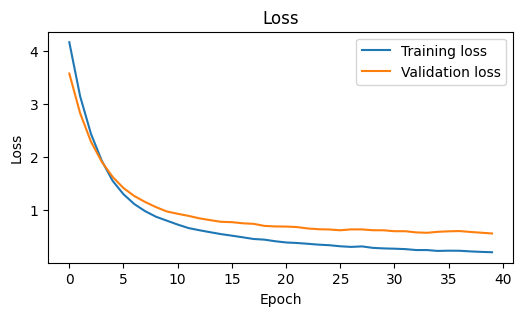

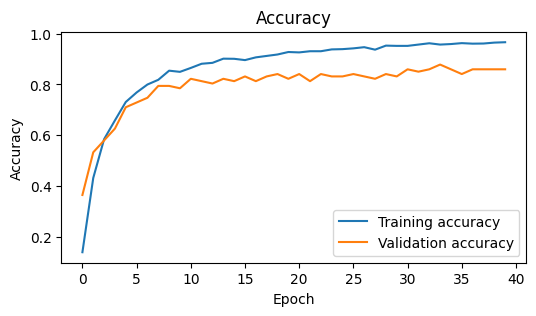

In [42]:
history = np.load('../data/result/historyh.npy', allow_pickle=True).item()

# Plot the loss history
plt.figure(figsize=(6, 3))
plt.plot(history["train_loss"], label='Training loss')
plt.plot(history["val_loss"], label='Validation loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig("../data/figure/loss.png", bbox_inches='tight')

plt.figure(figsize=(6, 3))
plt.plot(history["train_accuracy"], label='Training accuracy')
plt.plot(history["val_accuracy"], label='Validation accuracy')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("../data/figure/accuracy.png", bbox_inches='tight')

# max accuracy
print("max training accuracy",max(history["train_accuracy"]))
print("max validation accuracy",max(history["val_accuracy"]))

